# XGBoost на практике: регрессия и классификация на реальных данных

В этом ноутбуке мы подробно разберём библиотеку **XGBoost** на двух задачах:

- **регрессия** на датасете *California Housing*;
- **классификация** на более сложном многоклассовом датасете *Covertype*.

Мы рассмотрим:

- базовое применение `XGBRegressor` и `XGBClassifier`;
- ключевые элементы теории (градиентный бустинг второго порядка, регуляризация и сэмплирование);
- влияние важнейших гиперпараметров на качество (глубина дерева, сэмплирование, регуляризация);
- визуализацию результатов и важностей признаков.

Предполагается, что вы уже знакомы с деревьями решений, Random Forest и базовым градиентным бустингом из `sklearn`. Здесь мы фокусируемся именно на **особенностях XGBoost** и его поведении на относительно больших и сложных датасетах.

## 1. Импорт библиотек и подготовка данных

Используем два датасета из `sklearn`:

- `fetch_california_housing` — задача регрессии (цены на жильё в Калифорнии);
- `fetch_covtype` — задача многоклассовой классификации типов лесного покрова (сложный, крупный датасет).

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing, fetch_covtype
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    accuracy_score,
    f1_score,
    confusion_matrix
)

from xgboost import XGBRegressor, XGBClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression

# Настройки отображения
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['figure.dpi'] = 120

RANDOM_STATE = 42

### 1.1. Датасет для регрессии: California Housing

Датасет содержит информацию о районах в Калифорнии и среднюю стоимость жилья в каждом районе.

Целевая переменная: `MedHouseVal` — средняя стоимость дома (в сотнях тысяч долларов).

Признаки:
- `MedInc` — медианный доход;
- `HouseAge` — медианный возраст домов;
- `AveRooms`, `AveBedrms`, `AveOccup` и др.

In [20]:
california = fetch_california_housing(as_frame=True)
X_reg = california.data
y_reg = california.target

print('Shape:', X_reg.shape)
X_reg.head()

Shape: (20640, 8)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


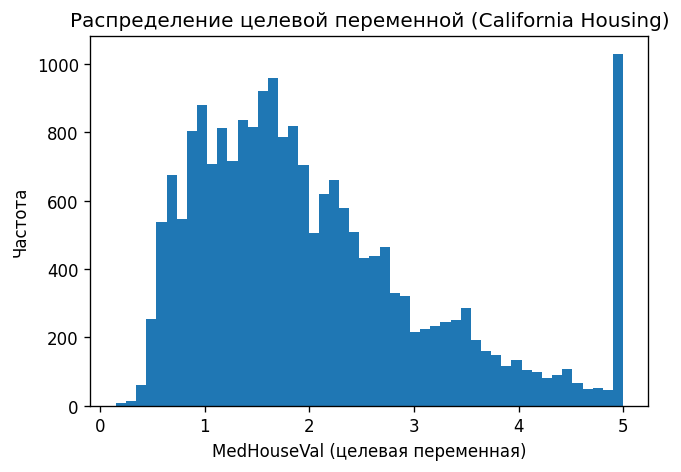

In [21]:
plt.hist(y_reg, bins=50)
plt.xlabel('MedHouseVal (целевая переменная)')
plt.ylabel('Частота')
plt.title('Распределение целевой переменной (California Housing)')
plt.show()

In [22]:
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)
X_reg_train.shape, X_reg_test.shape

((16512, 8), (4128, 8))

### 1.2. Датасет для классификации: Covertype

Датасет **Covertype** содержит данные о типе лесного покрова в разных участках территории США.

- Целевая переменная — тип лесного покрова (7 классов);
- Признаки — высота, уклон, расстояние до водоёмов/дорог, почвенные характеристики и т.д.

Это достаточно **крупный и сложный** датасет, хорошо подходящий для демонстрации преимуществ бустинга.

Чтобы не перегружать вычисления, мы возьмём случайную подвыборку объектов.

In [23]:
covtype = fetch_covtype(as_frame=True)
X_clf_full = covtype.data
y_clf_full = covtype.target

print('Полный датасет Covertype:', X_clf_full.shape)

# Возьмём подвыборку для ускорения (например, 50000 объектов)
n_samples = 50000
rng = np.random.RandomState(RANDOM_STATE)
indices = rng.choice(len(X_clf_full), size=n_samples, replace=False)

X_clf = X_clf_full.iloc[indices].reset_index(drop=True)
y_clf = y_clf_full.iloc[indices].reset_index(drop=True)

X_clf.shape, y_clf.value_counts().sort_index()

Полный датасет Covertype: (581012, 54)


((50000, 54),
 Cover_Type
 1    18401
 2    24299
 3     3082
 4      222
 5      796
 6     1463
 7     1737
 Name: count, dtype: int64)

In [56]:
X_clf.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,3351.0,206.0,27.0,726.0,124.0,3813.0,192.0,252.0,180.0,2271.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2732.0,129.0,7.0,212.0,1.0,1082.0,231.0,236.0,137.0,912.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2572.0,24.0,9.0,201.0,25.0,957.0,216.0,222.0,142.0,2191.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2824.0,69.0,13.0,417.0,39.0,3223.0,233.0,214.0,110.0,6478.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2529.0,84.0,5.0,120.0,9.0,1092.0,227.0,231.0,139.0,4983.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=RANDOM_STATE, stratify=y_clf
)
X_clf_train.shape, X_clf_test.shape

((40000, 54), (10000, 54))

## 2. XGBoost: ключевые идеи и зачем они нужны

XGBoost — это реализация градиентного бустинга по деревьям решений с несколькими важными улучшениями, которые делают его **быстрым, устойчивым и эффективным** на табличных данных.

### 2.1. Бустинг второго порядка

В классическом градиентном бустинге на шаге $m$ мы используем только **градиент** функции потерь:
$g_i = \partial L(y_i, f(x_i)) / \partial f$. XGBoost дополнительно использует вторую производную:
$h_i = \partial^2 L(y_i, f(x_i)) / \partial f^2$.

На шаге $m$ минимизируется квадратичная аппроксимация функции потерь:

$$
\mathcal{L}^{(m)} \approx \sum_i \left[g_i h_m(x_i) + \frac{1}{2} h_i h_m(x_i)^2\right] + \Omega(h_m),
$$

где $h_m(x)$ — новое дерево, а $\Omega(h_m)$ — регуляризация дерева.

**Зачем это нужно?**

- Использование второй производной даёт более точное направление шага (аналог метода Ньютона);
- модель может быстрее и стабильнее сходиться;
- особенно полезно при сложных и «жёстких» функциях потерь.

### 2.2. Регуляризация структуры дерева

Регуляризационный член имеет вид:

$$
\Omega(h_m) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^T w_j^2,
$$

где:

- $T$ — число листьев в дереве,
- $w_j$ — вес предсказания в $j$-м листе,
- $\gamma$ — штраф за добавление листа,
- $\lambda$ — коэффициент L2-регуляризации весов листьев.

**Зачем это нужно?**

- Штраф по числу листьев ограничивает «разрастание» деревьев и уменьшает переобучение;
- L2-регуляризация весов листьев сглаживает предсказания и делает модель более устойчивой к шуму;
- XGBoost превращается не просто в бустинг по деревьям, а в *регуляризованный оптимизатор структуры деревьев*.

### 2.3. Работа с разреженными и пропущенными значениями

XGBoost умеет автоматически обрабатывать разреженные матрицы и пропуски:

- при поиске сплита он может оптимально выбирать, в какую ветку отправлять объекты с пропусками;
- эффективно хранятся и обрабатываются sparse-признаки (one-hot, TF-IDF и т.д.).

**Зачем это нужно?**

- не нужно заранее вручную заполнять все пропуски;
- удобно работать с one-hot-кодированием даже при большом количестве категорий;
- ускоряется обучение на высокоразреженных признаках.

### 2.4. Сэмплирование по объектам и признакам

Параметры:

- `subsample` — доля объектов, используемых для каждого дерева;
- `colsample_bytree` — доля признаков, используемых для каждого дерева.

**Зачем это нужно?**

- уменьшает коррелированность деревьев;
- снижает дисперсию ансамбля (аналог идеи Random Forest);
- ускоряет обучение (меньше объектов/признаков на итерацию);
- помогает бороться с переобучением.

### 2.5. Высокопроизводительная реализация

XGBoost реализован на C++ с поддержкой:

- многопоточной обработки;
- эффективного хранения и сортировки признаков;
- (при необходимости) обучения на GPU.

**Зачем это нужно?**

- можно обучать модели на сотнях тысяч и миллионах объектов;
- можно использовать XGBoost как рабочую лошадку в продакшене;
- он стал де-факто стандартом для соревнований по табличным данным.

### 2.6. Как XGBoost работает с категориальными признаками

Исторически XGBoost ориентирован на **числовые** признаки. Категориальные признаки он напрямую не обрабатывает: модель видит только матрицу чисел и режет признаки порогами.

Базовая и наиболее надёжная практика:

1. **Все категориальные признаки нужно заранее закодировать.**
   Типичные варианты:
   - One-Hot Encoding (`pd.get_dummies`, `OneHotEncoder` в `sklearn`);
   - Target/Mean Encoding (осторожно с утечкой таргета: нужно делать по train-фолдам);
   - Ordinal Encoding (целые коды категорий, если порядок не важен и модель — дерево).

2. После кодирования XGBoost получает уже **полностью числовую** матрицу признаков и работает с ней как обычно:
   - мы используем `XGBRegressor` / `XGBClassifier` из `xgboost.sklearn` API;
   - никаких дополнительных параметров про категориальные признаки передавать не нужно.

3. В этом ноутбуке все признаки уже числовые (в том числе «категориальные» части могут быть представлены dummy-признаками), поэтому мы не демонстрируем отдельную обработку категориальных признаков для XGBoost.  
   В реальных задачах с «сырыми» категориальными текстовыми полями (город, бренд, модель устройства и т.п.) их нужно **явно преобразовать в числа** до подачи в XGBoost.


## 3. Регрессия с XGBRegressor

Начнём с задачи регрессии на датасете California Housing. Будем предсказывать среднюю стоимость жилья.

### 3.1. Бэйзлайны: линейная регрессия и RandomForestRegressor

Сначала построим два бэйзлайна:

- простая **линейная регрессия** (LinearRegression);
- ансамблевый метод **RandomForestRegressor**.

Это позволит понять, насколько XGBoost даёт выигрыш по сравнению с классическими методами.

In [25]:
# Линейная регрессия
lin_reg = LinearRegression()
lin_reg.fit(X_reg_train, y_reg_train)
y_pred_lin = lin_reg.predict(X_reg_test)

mae_lin = mean_absolute_error(y_reg_test, y_pred_lin)
rmse_lin = np.sqrt(mean_squared_error(y_reg_test, y_pred_lin))
r2_lin = r2_score(y_reg_test, y_pred_lin)

print(f'LinearRegression MAE:  {mae_lin:.4f}')
print(f'LinearRegression RMSE: {rmse_lin:.4f}')
print(f'LinearRegression R2:   {r2_lin:.4f}')

LinearRegression MAE:  0.5332
LinearRegression RMSE: 0.7456
LinearRegression R2:   0.5758


In [26]:
# RandomForestRegressor
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
rf_reg.fit(X_reg_train, y_reg_train)
y_pred_rf = rf_reg.predict(X_reg_test)

mae_rf = mean_absolute_error(y_reg_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_reg_test, y_pred_rf))
r2_rf = r2_score(y_reg_test, y_pred_rf)

print(f'RandomForestRegressor MAE:  {mae_rf:.4f}')
print(f'RandomForestRegressor RMSE: {rmse_rf:.4f}')
print(f'RandomForestRegressor R2:   {r2_rf:.4f}')

RandomForestRegressor MAE:  0.3266
RandomForestRegressor RMSE: 0.5034
RandomForestRegressor R2:   0.8066


In [27]:
baseline_df = pd.DataFrame({
    'Model': ['LinearRegression', 'RandomForestRegressor'],
    'MAE': [mae_lin, mae_rf],
    'RMSE': [rmse_lin, rmse_rf],
    'R2': [r2_lin, r2_rf]
})
baseline_df

,Model,MAE,RMSE,R2
0,LinearRegression,0.533200,0.745581,0.575788
1,RandomForestRegressor,0.326569,0.503374,0.806636


### 3.2. Базовая модель XGBRegressor

Теперь обучим XGBoost-регрессор с умеренными значениями гиперпараметров и сравним его с бэйзлайнами.

In [28]:
xgb_reg_base = XGBRegressor(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_reg_base.fit(X_reg_train, y_reg_train)
y_pred_xgb = xgb_reg_base.predict(X_reg_test)

mae_xgb = mean_absolute_error(y_reg_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_reg_test, y_pred_xgb))
r2_xgb = r2_score(y_reg_test, y_pred_xgb)

print(f'XGBRegressor MAE:  {mae_xgb:.4f}')
print(f'XGBRegressor RMSE: {rmse_xgb:.4f}')
print(f'XGBRegressor R2:   {r2_xgb:.4f}')

XGBRegressor MAE:  0.2960
XGBRegressor RMSE: 0.4514
XGBRegressor R2:   0.8445


In [29]:
new_row = pd.DataFrame({
    'Model': ['XGBRegressor'],
    'MAE': [mae_xgb],
    'RMSE': [rmse_xgb],
    'R2': [r2_xgb]
})

all_reg_df = pd.concat([baseline_df, new_row], ignore_index=True)
all_reg_df

,Model,MAE,RMSE,R2
0,LinearRegression,0.533200,0.745581,0.575788
1,RandomForestRegressor,0.326569,0.503374,0.806636
2,XGBRegressor,0.295974,0.451392,0.844511


### 3.3. Визуализация предсказаний XGBRegressor

Посмотрим, насколько хорошо предсказания XGBoost совпадают с истинными значениями.

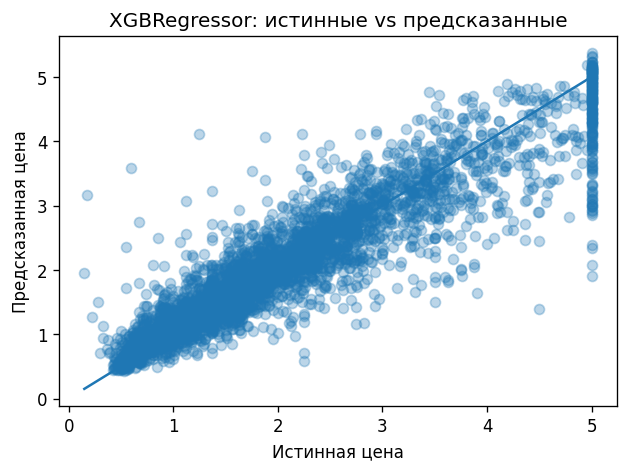

In [30]:
plt.figure()
plt.scatter(y_reg_test, y_pred_xgb, alpha=0.3)
plt.xlabel('Истинная цена')
plt.ylabel('Предсказанная цена')
plt.title('XGBRegressor: истинные vs предсказанные')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()])
plt.show()

## 4. Регрессия: влияние гиперпараметров XGBoost

Начнём с того, как глубина деревьев (`max_depth`) влияет на качество.

### 4.1. Эксперимент: `max_depth`

Изменяем `max_depth` и смотрим на MAE, RMSE и $R^2$.

In [31]:
depths = [2, 3, 4, 6, 8]
results_depth = []

for d in depths:
    model = XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=d,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective='reg:squarederror',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    model.fit(X_reg_train, y_reg_train)
    preds = model.predict(X_reg_test)
    mae = mean_absolute_error(y_reg_test, preds)
    rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
    r2 = r2_score(y_reg_test, preds)
    results_depth.append((d, mae, rmse, r2))

df_depth = pd.DataFrame(results_depth, columns=['max_depth', 'MAE', 'RMSE', 'R2'])
df_depth

,max_depth,MAE,RMSE,R2
0,2,0.377714,0.552379,0.767155
1,3,0.344733,0.508287,0.802844
2,4,0.322836,0.481397,0.823152
3,6,0.295974,0.451392,0.844511
4,8,0.289322,0.446408,0.847926


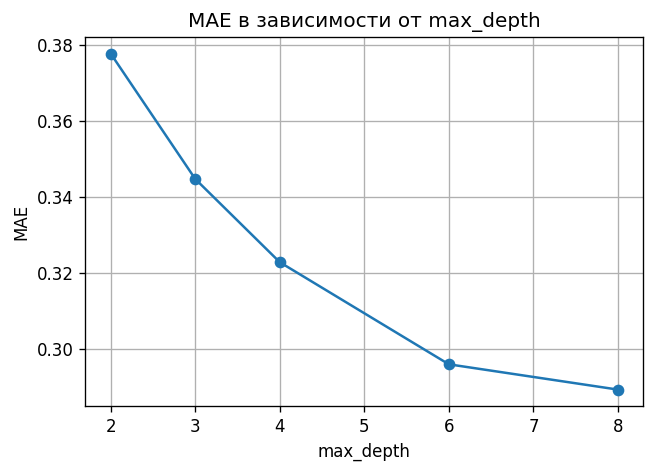

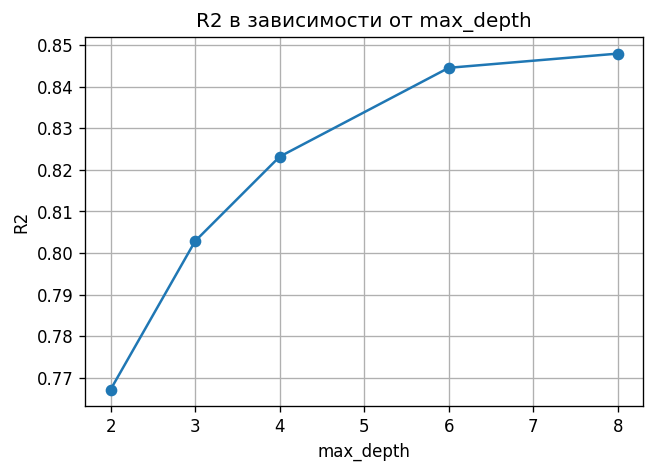

In [32]:
plt.figure()
plt.plot(df_depth['max_depth'], df_depth['MAE'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('MAE')
plt.title('MAE в зависимости от max_depth')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_depth['max_depth'], df_depth['R2'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('R2')
plt.title('R2 в зависимости от max_depth')
plt.grid(True)
plt.show()

### 4.2. Эксперимент: `subsample` и `colsample_bytree`

Параметры `subsample` (строки) и `colsample_bytree` (столбцы) задают долю объектов и признаков, используемых для каждого дерева. Они уменьшают переобучение и ускоряют обучение.

In [57]:
subsamples = [0.6, 0.8, 1.0]
colsamples = [0.6, 0.8, 1.0]

results_sample = []

for ss in subsamples:
    for cs in colsamples:
        model = XGBRegressor(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=4,
            subsample=ss,
            colsample_bytree=cs,
            reg_lambda=1.0,
            objective='reg:squarederror',
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
        model.fit(X_reg_train, y_reg_train)
        preds = model.predict(X_reg_test)
        mae = mean_absolute_error(y_reg_test, preds)
        rmse = np.sqrt(mean_squared_error(y_reg_test, preds))
        r2 = r2_score(y_reg_test, preds)
        results_sample.append((ss, cs, mae, rmse, r2))

df_sample = pd.DataFrame(results_sample, columns=['subsample', 'colsample_bytree', 'MAE', 'RMSE', 'R2'])
df_sample

,subsample,colsample_bytree,MAE,RMSE,R2
0,0.6,0.6,0.329717,0.487080,0.818952
1,0.6,0.8,0.326175,0.485092,0.820427
2,0.6,1.0,0.323300,0.482249,0.822526
3,0.8,0.6,0.330466,0.486416,0.819445
4,0.8,0.8,0.322239,0.480936,0.823491
5,0.8,1.0,0.321400,0.479507,0.824538
6,1.0,0.6,0.329222,0.485493,0.820130
7,1.0,0.8,0.323201,0.480977,0.823461
8,1.0,1.0,0.325643,0.486045,0.819720


## 5. Регрессия: важности признаков

Посмотрим, какие признаки наиболее важны для XGBoost-регрессора на California Housing.

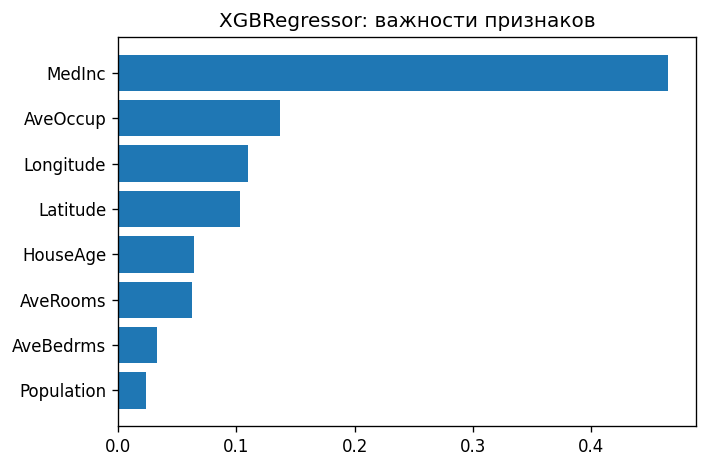

In [34]:
importances_reg = xgb_reg_base.feature_importances_
feature_names_reg = X_reg.columns

order = np.argsort(importances_reg)

plt.figure(figsize=(6, 4))
plt.barh(range(len(importances_reg)), importances_reg[order])
plt.yticks(range(len(importances_reg)), feature_names_reg[order])
plt.title('XGBRegressor: важности признаков')
plt.tight_layout()
plt.show()

## 6. Классификация с XGBClassifier (многоклассовая задача)

Теперь рассмотрим задачу многоклассовой классификации на Covertype. Это более сложная постановка, чем бинарная классификация на простом датасете.

### 6.1. Бэйзлайн: многоклассовая логистическая регрессия

В качестве отправной точки используем `LogisticRegression` с многоклассовой логистикой

In [ ]:
# Преобразуем метки классов чтобы они начинались с 0
y_clf -= 1
y_clf_train -= 1
y_clf_test -= 1

In [39]:
log_reg_clf = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg_clf.fit(X_clf_train, y_clf_train)
y_pred_log = log_reg_clf.predict(X_clf_test)

acc_log = accuracy_score(y_clf_test, y_pred_log)
f1_log = f1_score(y_clf_test, y_pred_log, average='macro')

print(f'LogisticRegression accuracy: {acc_log:.4f}')
print(f'LogisticRegression macro-F1: {f1_log:.4f}')

LogisticRegression accuracy: 0.6898
LogisticRegression macro-F1: 0.3631


In [43]:
# Вычисляется довольно долго

from sklearn.ensemble import RandomForestClassifier

for_reg_clf = RandomForestClassifier(n_estimators=300, max_depth=20, n_jobs=-1)
for_reg_clf.fit(X_clf_train, y_clf_train)
y_pred_for = for_reg_clf.predict(X_clf_test)

acc_for = accuracy_score(y_clf_test, y_pred_for)
f1_for = f1_score(y_clf_test, y_pred_for, average='macro')

print(f'RandomForestClassifier accuracy: {acc_for:.4f}')
print(f'RandomForestClassifier macro-F1: {f1_for:.4f}')

RandomForestClassifier accuracy: 0.8469
RandomForestClassifier macro-F1: 0.7518


In [48]:
# Вычисляется очень долго

from sklearn.ensemble import GradientBoostingClassifier

gb_reg_clf = GradientBoostingClassifier(n_estimators=100, max_depth=3)
gb_reg_clf.fit(X_clf_train, y_clf_train)
y_pred_gb = gb_reg_clf.predict(X_clf_test)

acc_gb = accuracy_score(y_clf_test, y_pred_gb)
f1_gb = f1_score(y_clf_test, y_pred_gb, average='macro')

print(f'GradientBoostingClassifier accuracy: {acc_gb:.4f}')
print(f'GradientBoostingClassifier macro-F1: {f1_gb:.4f}')

GradientBoostingClassifier accuracy: 0.7680
GradientBoostingClassifier macro-F1: 0.6606


### 6.2. Базовая модель XGBClassifier (multi:softprob)

Для многоклассовой задачи используем `objective='multi:softprob'` и указываем `num_class` (число классов).

In [49]:
n_classes = y_clf.nunique()

xgb_clf_base = XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    objective='multi:softprob',
    num_class=n_classes,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_clf_base.fit(X_clf_train, y_clf_train)
y_pred_xgb_clf = xgb_clf_base.predict(X_clf_test)

acc_xgb = accuracy_score(y_clf_test, y_pred_xgb_clf)
f1_xgb = f1_score(y_clf_test, y_pred_xgb_clf, average='macro')

print(f'XGBClassifier accuracy: {acc_xgb:.4f}')
print(f'XGBClassifier macro-F1: {f1_xgb:.4f}')

XGBClassifier accuracy: 0.8903
XGBClassifier macro-F1: 0.8294


In [50]:
clf_compare_df = pd.DataFrame({
    'Model': ['LogisticRegression', 'RandomForestClassifier', 'GradientBoostingClassifier', 'XGBClassifier'],
    'Accuracy': [acc_log, acc_for, acc_gb, acc_xgb],
    'Macro-F1': [f1_log, f1_for, f1_gb, f1_xgb]
})
clf_compare_df

,Model,Accuracy,Macro-F1
0,LogisticRegression,0.6898,0.363122
1,RandomForestClassifier,0.8469,0.751753
2,GradientBoostingClassifier,0.7680,0.660570
3,XGBClassifier,0.8903,0.829382


### 6.3. Матрица ошибок

Построим матрицу ошибок для XGBClassifier, чтобы понять, какие классы путаются между собой.

In [51]:
cm = confusion_matrix(y_clf_test, y_pred_xgb_clf)
cm

array([[3237,  420,    0,    0,    2,    0,   21],
       [ 335, 4479,   30,    0,    3,   12,    1],
       [   0,   20,  560,    1,    0,   36,    0],
       [   0,    0,   11,   32,    0,    1,    0],
       [   2,   73,    5,    0,   79,    0,    0],
       [   1,   27,   48,    2,    0,  215,    0],
       [  41,    5,    0,    0,    0,    0,  301]])

### 6.4. Классификация: влияние `max_depth`

Посмотрим, как глубина дерева влияет на качество в многоклассовой задаче.

In [53]:
depths_clf = [4, 6, 8, 10]
results_clf_depth = []

for d in depths_clf:
    print(f"Current depth: {d}")
    model = XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=d,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        objective='multi:softprob',
        num_class=n_classes,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    model.fit(X_clf_train, y_clf_train)
    pred = model.predict(X_clf_test)
    acc = accuracy_score(y_clf_test, pred)
    f1 = f1_score(y_clf_test, pred, average='macro')
    results_clf_depth.append((d, acc, f1))

df_clf_depth = pd.DataFrame(results_clf_depth, columns=['max_depth', 'accuracy', 'macro_F1'])
df_clf_depth

Current depth: 4
Current depth: 6
Current depth: 8
Current depth: 10


,max_depth,accuracy,macro_F1
0,4,0.8023,0.738128
1,6,0.8500,0.795283
2,8,0.8837,0.822063
3,10,0.8991,0.838671


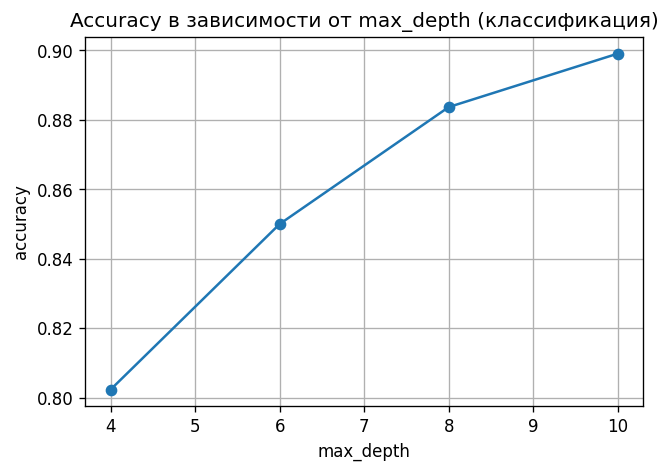

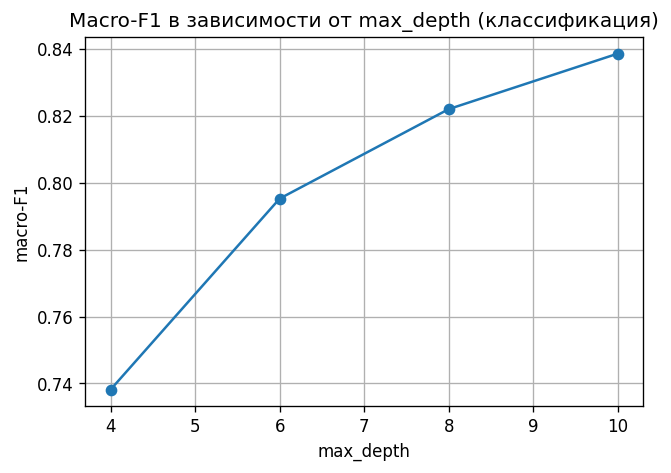

In [54]:
plt.figure()
plt.plot(df_clf_depth['max_depth'], df_clf_depth['accuracy'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Accuracy в зависимости от max_depth (классификация)')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(df_clf_depth['max_depth'], df_clf_depth['macro_F1'], marker='o')
plt.xlabel('max_depth')
plt.ylabel('macro-F1')
plt.title('Macro-F1 в зависимости от max_depth (классификация)')
plt.grid(True)
plt.show()

### 6.5. Важности признаков (классификация)

Посмотрим, какие признаки оказывают наибольшее влияние на решение XGBClassifier.

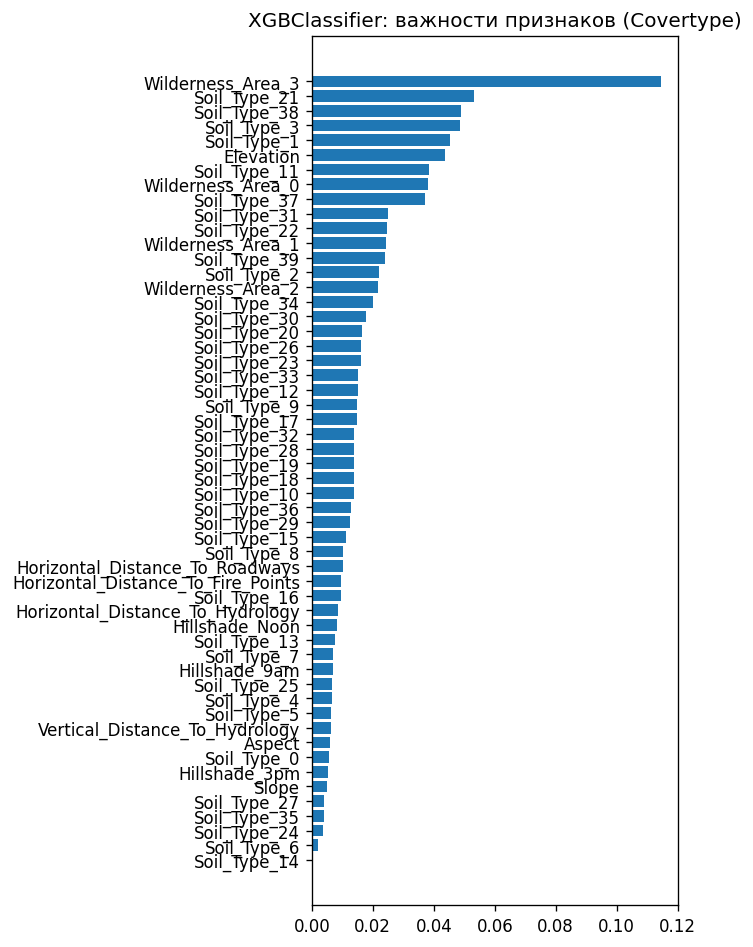

In [55]:
importances_clf = xgb_clf_base.feature_importances_
feature_names_clf = X_clf.columns

order_clf = np.argsort(importances_clf)

plt.figure(figsize=(6, 8))
plt.barh(range(len(importances_clf)), importances_clf[order_clf])
plt.yticks(range(len(importances_clf)), feature_names_clf[order_clf])
plt.title('XGBClassifier: важности признаков (Covertype)')
plt.tight_layout()
plt.show()

## 7. Выводы

В этом ноутбуке мы:

- применили **XGBRegressor** к задаче регрессии California Housing и сравнили его с:
  - линейной регрессией;
  - RandomForestRegressor;
- увидели, что XGBoost даёт заметный выигрыш по MAE, RMSE и $R^2$ на сложной табличной задаче;
- исследовали влияние глубины дерева (`max_depth`) и параметров сэмплирования (`subsample`, `colsample_bytree`) на качество регрессии;
- проанализировали важности признаков для регрессии;
- применили **XGBClassifier** к многоклассовой задаче Covertype и сравнили его с многоклассовой логистической регрессией по accuracy и macro-F1;
- посмотрели, как `max_depth` влияет на качество классификации и какие признаки оказываются наиболее важными.

Основные практические выводы:

- XGBoost — мощный универсальный метод для табличных данных (регрессия и классификация), особенно на больших и сложных датасетах;
- глубина дерева и регуляризация критически важны для контроля переобучения;
- стохастическое сэмплирование по объектам и признакам помогает уменьшать дисперсию и ускорять обучение;
- анализ важностей признаков позволяет понять структуру задачи и проверить здравый смысл модели.

В отдельных ноутбуках можно аналогичным образом разобрать **LightGBM** и **CatBoost**, а затем сравнить все три бустинга на одних и тех же задачах.